In [1]:
import numpy as np
from clockprocesses import *
import matplotlib.pyplot as plt

In [2]:
#Carry out tests on sinusoidal signals
N = 1000
tp = 1
dt = tp/N
sin = lambda x: np.sin(10 * np.pi * x)

#Stochastic clock parameters
X0 = np.array([0, 0]) #Initial conditions set to zero
mu = np.array([1, 0]) #Average rate of clock increase = 1, no drift/slowing

The `mu` variable is the drift parameters for the Wiener processes that affect the noise in
a Caesium clock as defined by:

$$
\begin{equation*}
    \begin{array}{c}
        dX_1 (t) = (X_2(t) + \mu_1) dt + \sigma_1 dW_1(t) \\\
        dX_2 (t) = \mu_2 dt + \sigma_2 dW_2(t)
    \end{array}
\end{equation*}
$$

where $W(t) \sim \mathcal{N}(0, t)$. The drift terms are deterministic, hence setting them to 
zero will not affect the stochasticity of the clock noise.

However, setting $\mu_1 = 1$ means that in the iterative solution each successive timepoint has 
$\delta t$ added, so the output changes from stochastic deviations to the stochastic 
timegrid.

From the output vector $\mathbf{X}(t) = \begin{pmatrix}X_1(t) \\\ X_2(t) \end{pmatrix}$, the
time-phase deviation $X_1(t)$ is extracted by the functions of `stochasticclock`. $X_2(t)$
is not used past calculations since it only a component of the clock frequency deviation.

In [3]:
#Perfect clock
sigma_perfect = np.array([0, 0]) #No stochastic noise
timegrid = stochastic_clock(tp=tp, N=N, X0=X0, mu=mu, sigma=sigma_perfect)

#Original non-stochastic timegrid
t_perfect = timegrid['perfect'] 
#Timegrid with stochastic deviations (same as t_original for a perfect clock)
t_stochastic = timegrid['stochastic'] 
#The deviations in each timepoint between the perfect and stochastic timegrids
deviation = timegrid['deviation']  

max_deviation = np.max(np.abs(t_perfect-t_stochastic)) 
print(f'Maxmimum deviation = {max_deviation}')
#A perfect clock should have no deviations (accounting for machine error)
print(f'No time deviations = {np.all(deviation < np.finfo(deviation.dtype).eps)}')

Maxmimum deviation = 7.771561172376096e-16
No time deviations = True


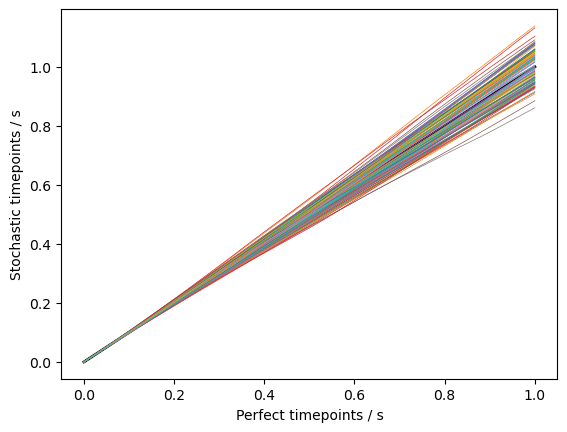

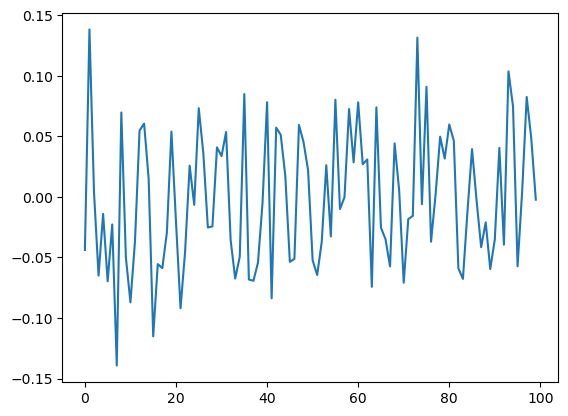

In [4]:
#Stochasticity 
sigma = np.array([0, 0.1])

#Plot figures
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
timegrid_length = [] 

#Plot for a perfect clock
ax1.plot(timegrid['perfect'], timegrid['perfect'], c='k', lw=2) 

for _ in range(100):
    timegrid = stochastic_clock(tp=tp, N=N, X0=X0, mu=mu, sigma=sigma)
    t_perfect = timegrid['perfect'] 
    t_stochastic = timegrid['stochastic'] 
    #The difference in total time between the two timegrids
    timegrid_length.append(t_stochastic[-1] - t_perfect[-1])

    #Plot the stochastic timegrid against the perfect timegrid
    ax1.plot(t_perfect, t_stochastic, lw=0.5)
    ax1.set_xlabel('Perfect timepoints / s')
    ax1.set_ylabel('Stochastic timepoints / s')

ax2.plot(timegrid_length)

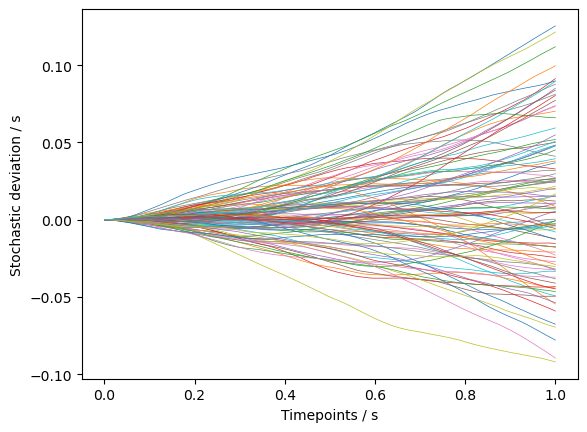

In [5]:
#Stochasticity - divergence of timegrids
sigma = np.array([0, 0.1])
#If the stochastic timegrid is not needed, and only the deviations, set mu to zero
mu = np.zeros(2) 

fig3, ax3 = plt.subplots()
for _ in range(100):
    timegrid = stochastic_clock(tp=tp, N=N, X0=X0, mu=mu, sigma=sigma)
    t_perfect = timegrid['perfect'] 
    deviation = timegrid['deviation'] 

    ax3.plot(t_perfect, deviation, lw=0.5)
    ax3.set_xlabel('Timepoints / s')
    ax3.set_ylabel('Stochastic deviation / s')

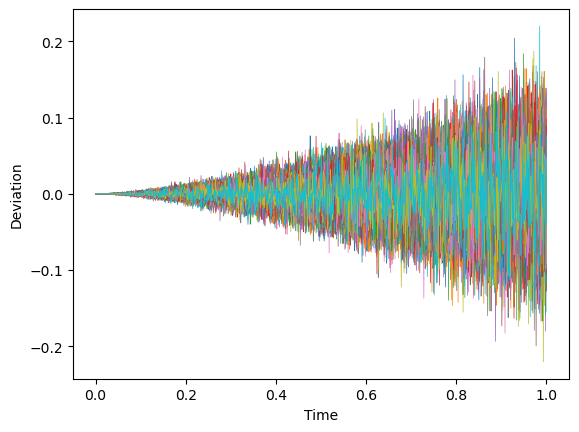

In [6]:
#Deviation distribution
sigma = np.array([0, 0.1])
mu = np.zeros(2) 

fig5, ax5 = plt.subplots()

for _ in range(100):
    #method='distribution' to generate the multivariate Gaussian distribution of 
    #deviations at each timepoint
    timegrid = stochastic_clock(tp=tp, N=N, X0=X0, mu=mu, sigma=sigma, 
                                method='distribution')
    
    ax5.plot(timegrid['perfect'], timegrid['deviation'], lw=0.5)
    ax5.set_xlabel('Time')
    ax5.set_ylabel('Deviation')

The stochastic deviations at timepoint $t_n$ for zero initial conditions follow the
distribution

$$
\begin{equation*}
    \mathbf{X}(t_n) \sim \mathcal{N} \bigg(
        \begin{bmatrix}
            \mu_1 t_n + \frac{1}{2} \mu_2 t_n^2 \\\
            \mu_2 t_n
        \end{bmatrix}
    , 
        \begin{bmatrix}
                \sigma_1^2 \delta t + \frac{1}{3} \sigma_2^2 \delta t^3 & \frac{1}{2}\sigma_2^2 \delta t^2 \\\ 
                \frac{1}{2}\sigma_2^2 \delta t^2 & \sigma_2^2 \delta t 
        \end{bmatrix} 
    \bigg)
\end{equation*}
$$

While it can be used to simulate stochastic clock noise, the rapid modulation in deviation 
due to scaling of the covariance with timepoint $t_n$ makes this unfeasible and unrealistic. Rather, the above plot simulates the distribution of deviations at each timepoint.

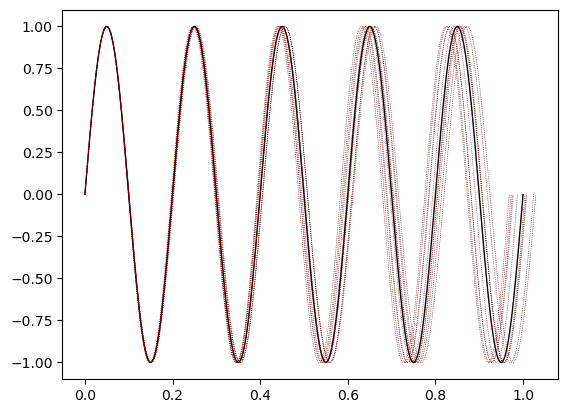

In [7]:
#Visualizing the effect of stochastic clock noise on a signal
sigma = np.array([0, 0.03])
mu = np.array([1, 0])

fig4, ax4 = plt.subplots()
#Sinusoidal signals
time = np.linspace(0, tp, N+1)
sin_amplitudes = sin(time)
ax4.plot(time, sin_amplitudes, lw=1, c='k')

#Plot the sinusoidal signals on a stochastic timegrid
for _ in range(10):
    timegrid = stochastic_clock(tp=tp, N=N, X0=X0, mu=mu, sigma=sigma)
    ax4.plot(timegrid['stochastic'], sin_amplitudes, lw=0.5, c='maroon', linestyle=':')

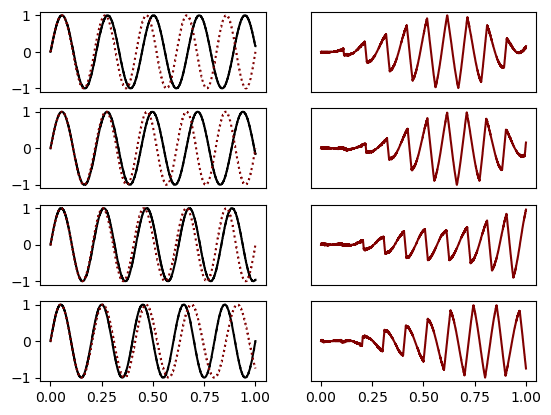

In [8]:
#Clock error test
sigma = np.array([0, 0.1])
mu = np.array([1, 0])

fig5, ax5 = plt.subplots(4,2)

for i in range(4):
    timegrid = stochastic_clock(tp=tp, N=N, X0=X0, mu=mu, sigma=sigma)
    sin_amplitudes = sin(timegrid['perfect'])
    
    #The clock_error function is only for visualisation purposes and does not provide a 
    #metric for error
    signal, signal_stochastic = clock_error(timegrid=timegrid['perfect'],
                                            timegrid_stochastic=timegrid['stochastic'],
                                            amplitudes=sin_amplitudes)
    #signal[0] = timepoints and signal[1] = amplitudes
    #Plot the stochastic and non-stochastic signals on the same timegrid
    ax5[i][0].plot(signal[0], signal[1], c='k')
    ax5[i][0].plot(signal_stochastic[0], signal_stochastic[1], c='maroon', linestyle=':')

    #Plot the absolute difference in amplitudes between two signals
    amplitude_error = np.abs(signal[1]) - np.abs(signal_stochastic[1])
    ax5[i][1].plot(signal[0], amplitude_error, c='maroon')

    #Make the plots cleaner
    ax5[i][1].set_ylim(ax5[i][0].get_ylim())
    ax5[i][1].set_yticks([])
    if i != 3:
        ax5[i][0].set_xticks([])
        ax5[i][1].set_xticks([])